# Ocean Dependence

Visualizing marine protein consumption (as a proprotion of diet) in countries with high food insecurity.

*Author: Rachel Thoms
<br>Created: 04 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- [Dorling Cartogram](https://vega.github.io/vega/examples/dorling-cartogram/) 
- Size is proportion of protein consumption from marine protein (%) color is food insecurity (%)

## Data

- Data: [foo_061_rw0_blue_food_supply](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_061_rw0_blue_food_supply_edit) & [foo_064_rw0_food_insecurity](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_064_rw0_food_insecurity_edit)
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/9e1b3cad-db6f-44b0-b6fb-048df7b6c680)
- Source: [FAO Food Balance Sheet](http://www.fao.org/faostat/en/#data/FBS) & [FAO Food Security Indicators](http://www.fao.org/faostat/en/#data/FS)

## Vega

### Queries

Protein Supply

```sql
SELECT gadm.gid_0, gadm.name_0, year, 
    SUM(CASE WHEN type = 'Grand Total' THEN value ELSE 0 END) AS total, 
    SUM(CASE WHEN type = 'Ocean-Sourced Food' THEN value ELSE 0 END) AS ocean 
    FROM foo_061_rw0_blue_food_supply_edit data 
INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area  
INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE element = 'Protein supply quantity (g/capita/day)' AND year= 2018 
GROUP BY gadm.gid_0, gadm.name_0, year ORDER BY gid_0
```

Food Insecurity

```sql
SELECT gadm.gid_0, gadm.name_0, item as variable, y20182020 as value 
    FROM foo_064_rw0_food_insecurity_edit data 
INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 ORDER BY gid_0 ASC
```

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 800
widget_height = 400

## Resource Watch Widget Config

In [4]:
spec=json.loads("""{
  "autosize": "none",
  "data": [
    {
      "name": "protein",
      "format": {
        "property": "rows",
        "type": "json"
      },
      "transform": [

        {
          "as": "marine_protein_percent",
          "expr": "datum.total === 0 ? null : (datum.ocean/ datum.total)",
          "type": "formula"
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gadm.gid_0, gadm.name_0, year, SUM(CASE WHEN type = 'Grand Total' THEN value ELSE 0 END) AS total, SUM(CASE WHEN type = 'Ocean-Sourced Food' THEN value ELSE 0 END) AS ocean FROM foo_061_rw0_blue_food_supply_edit data INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area  INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE element = 'Protein supply quantity (g/capita/day)' AND year= 2018 GROUP BY gadm.gid_0, gadm.name_0, year ORDER BY gid_0"
    },
    {
      "format": {
        "property": "features",
        "type": "json"
      },
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT ST_Centroid(gadm.the_geom) AS the_geom, data.gid_0, data.name_0, data.variable, data.value, geostore_prod as geostore, '{{geostore_id}}' as id FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 ORDER BY gid_0 ASC"
    },
    {
      "name": "centroids",
      "source": "source",
      "transform": [
        {
          "as": "x_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? 175 : test(/WSM/, datum.properties.gid_0) ? 175: test(/TON/, datum.properties.gid_0) ? 180 : datum.geometry.coordinates[0]",
          "type": "formula"
        },
        {
          "as": "y_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? -5: test(/WSM/, datum.properties.gid_0) ? -10: test(/TON/, datum.properties.gid_0) ? -18: datum.geometry.coordinates[1]",
          "type": "formula"
        },

        {
          "fields": [
            "x_cart",
            "y_cart"
          ],
          "projection": "projection",
          "type": "geopoint"
        }
      ]
    },
    {
      "format": {
        "property": "rows",
        "type": "json"
      },
      "name": "foodSecurity",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gadm.gid_0, gadm.name_0, item as variable, y20182020 as value FROM foo_064_rw0_food_insecurity_edit data INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 ORDER BY gid_0 ASC",
      "transform": [
        {
          "as": "security",
          "expr": "isValid(datum.value) ? datum.value/100 : null",
          "type": "formula"
        },
        {
          "as": [
            "protein"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": ["geostore","id",
            "x","y"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "centroids",
          "key": "properties[gid_0]",
          "type": "lookup",
          "values": [
            "properties[geostore]", "properties[id]","x", "y"
          ]
        }
      ]
    },
    {
      "name": "transformed",
      "source": "foodSecurity",
      "transform": [
        {
          "as": "size",
          "expr": "3 + sqrt(scale('size', datum.security))/2.5",
          "type": "formula"
        },
        {
          "type": "force",
          "forces": [
            {
              "force": "collide",
              "radius": {
                "field": "size"
              },
              "iterations": 200,
              "strength": 0.9
            },
            {
              "force": "x",
              "x": {
                "field": "x"
              }
            },
            {
              "force": "y",
              "y": {
                "field": "y"
              }
            }
          ]
        },
        {
          "as": "x",
          "expr": "datum.x+datum.vx",
          "type": "formula"
        },
        {
          "as": "y",
          "expr": "datum.y+datum.vy",
          "type": "formula"
        }
      ]
    },
    { "name": "geom",
    "url": "https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.min.geojson",
    "format": {
      "property": "features",
      "type": "json"},
      "transform": [
        {
          "as": [
            "protein"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": ["security","geostore","id"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "foodSecurity",
          "key": "gid_0",
          "type": "lookup",
          "values": ["security","geostore","id"]
        }
      ]
    }
  ],
  "height": 400,
  "legends": [
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "fill": "color",
      "gradientThickness": 10,
      "labelFontSize": 10,
      "labelFont": "Lato",
      "orient": "bottom-left",
      "size": "color",
      "title": [
        "Proportion of protein supply",
        "from marine protein"
      ],
      "titleFontSize": 10,
      "titleFont": "Lato",
      "type": "gradient",
      "format": "%"
    },
    {
      "clipHeight": 20,
      "direction": "horizontal",
      "labelFontSize":10,
      "labelFont": "Lato",
      "format": "%",
      "orient": "bottom-left",
      "size": "size",
      "symbolFillColor": "white",
      "symbolStrokeColor": "lightgrey",
      "title": [
        "Prevalence of moderate to",
        "severe food insecurity"
      ],
       "titleFont": "Lato",
      "titleFontSize": 10,
      "type": "symbol"
    }
  ],
  "scales": [
    {
      "domain": {
        "data": "foodSecurity",
        "field": "security"
      },
      "name": "size",
      "range": {"signal": "[height/4,height]"}
    },
    {
      "domain": {
        "data": "foodSecurity",
        "field": "protein"
      },
      "domainMax": 0.11,
      "name": "color",
      "nice": true,
      "range": [
        "#bdd8ec",
        "#145fa6"
      ],
      "type": "linear"
    }
  ],
  "width": 800,
  "marks": [
    {
      "encode": {
        "enter": {
          "fill": [{"test": "isValid(datum.protein) & isValid(datum.security)", 
            "field": "protein",
            "scale": "color"},
            {"value": ["transparent"]}
          ],
          "size": {
            "field": "security",
            "scale": "size"
          },
          "stroke": [{"test": "datum.id === datum.geostore", "value": "gold"}, {"test": "isValid(datum.protein) & isValid(datum.security)", "value": "white"}, {"value": "transparent"}
          ],
          "strokeWidth": [
            {"test": "datum.id === datum.geostore", "value": 2},
            {"value": 0.5}],
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "transformed"
      },
      "name": "circles",
      "type": "symbol",
      "zindex": 1
    },
    {
      "encode": {
        "enter": {
          "align": {
            "value": "center"
          },
          "baseline": {
            "value": "middle"
          },
          "fill": [{"test": "isValid(datum.datum.security) && isValid(datum.datum.protein)", "value": "black"}, 
            {"value": "transparent"
          }],
          "fontSize": {
            "signal": "5"
          },
          "font": {
            "value": "Lato"
          },
          "text": {
            "field": "datum.gid_0"
          }
        },
        "update": {
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "circles"
      },
      "interactive": false,
      "type": "text",
      "zindex": 2
    },
    {
      "encode": {
        "enter": {
          "fill": {
            "value": "#f6f6f6"
          },
          "stroke": [{"test": "datum.id === datum.geostore && isValid(datum.geostore)", "value": "gold"},{
            "value": "transparent"
          }],
          "strokeWidth": {
            "value": 0.5
          }
        }
      },
      "from": {
        "data": "geom"
      },
      "transform": [
        {
          "projection": "projection",
          "type": "geoshape"
        }
      ],
      "type": "shape",
      "zindex": 0
    }
  ],
  "projections": [
    {
      "extent": {
        "signal": "[[-width/20,0],[width,height-height/4.5]]"
      },
      "clipExtent": {
        "signal": "[[0,0],[width,height-height/8]]"
      },
      "fit": {
        "signal": "data('source')"
      },
      "name": "projection",
      "type": "naturalEarth1"
    }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "properties.name",
            "property": "Location",
            "type": "text",
            "format": ""
          },
           {
            "column": "name_0",
            "property": "Location",
            "type": "text",
            "format": ""
          },
          {
            "column": "protein",
            "property": "Proportion of protein supply from marine protein",
            "type": "number",
            "format": ".2%"
          },
          {
            "column": "security",
            "property": "Prevalence of food insecurity",
            "type": "number",
            "format": ".2%"
          }
        ]
      }
    }
  ]
}""")
vega_view=dict(spec)

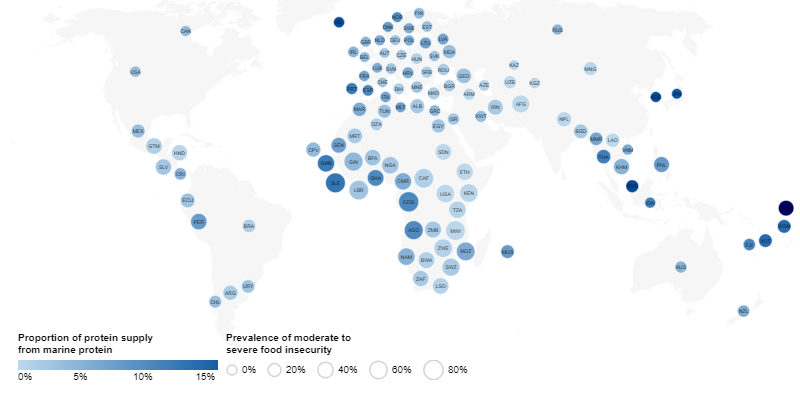

In [5]:
vega_view['legends'][0]['titleFont'] = 'Arial'
vega_view['legends'][1]['titleFont'] = 'Arial'
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][1]['labelFont'] = 'Arial'
vega_view['marks'][1]['encode']['enter']['font']['value'] = 'Arial'
Vega(vega_view)

# Indicator

No global indicator

## Country

Proportion of the global average of marine protein consumption is consumed by the country's population

#### Formatted
```sql
SELECT gid_0, SUM(value)/global_avg AS value 
FROM foo_061_rw0_blue_food_supply_edit country_data_v1
LEFT JOIN 
	(SELECT AVG(protein_supply) AS global_avg, 'Ocean-Sourced Food' AS type 
     FROM (SELECT area, SUM(value) as protein_supply 
           FROM foo_061_rw0_blue_food_supply_edit 
           WHERE element_code = 674 AND type = 'Ocean-Sourced Food' AND year = 2018 GROUP BY area) country_data_v2) global 
     ON global.type = country_data_v1.type
LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = country_data_v1.area
LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0
WHERE element_code = 674 AND country_data_v1.type = 'Ocean-Sourced Food' 
AND year = 2018 AND {{geostore_env}} ILIKE '{{geostore_id}}'
GROUP BY gid_0, global_avg
```

#### Raw
`https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, SUM(value)/global_avg AS value FROM foo_061_rw0_blue_food_supply_edit country_data_v1 LEFT JOIN (SELECT AVG(protein_supply) AS global_avg, 'Ocean-Sourced Food' AS type FROM (SELECT area, SUM(value) as protein_supply FROM foo_061_rw0_blue_food_supply_edit WHERE element_code = 674 AND type = 'Ocean-Sourced Food' AND year = 2018 GROUP BY area) country_data_v2) global ON global.type = country_data_v1.type LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = country_data_v1.area LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE element_code = 674 AND country_data_v1.type = 'Ocean-Sourced Food' AND year = 2018 AND {{geostore_env}} ILIKE '{{geostore_id}}' GROUP BY gid_0, global_avg`

#### [Demo](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20gid_0,%20SUM(value)/global_avg%20AS%20value%20FROM%20foo_061_rw0_blue_food_supply_edit%20country_data_v1%20LEFT%20JOIN%20(SELECT%20AVG(protein_supply)%20AS%20global_avg,%20%27Ocean-Sourced%20Food%27%20AS%20type%20FROM%20(SELECT%20area,%20SUM(value)%20as%20protein_supply%20FROM%20foo_061_rw0_blue_food_supply_edit%20WHERE%20element_code%20=%20674%20AND%20type%20=%20%27Ocean-Sourced%20Food%27%20AND%20year%20=%202018%20GROUP%20BY%20area)%20country_data_v2)%20global%20ON%20global.type%20=%20country_data_v1.type%20LEFT%20JOIN%20ow_aliasing_countries%20AS%20alias%20ON%20alias.alias%20=%20country_data_v1.area%20LEFT%20JOIN%20gadm36_0%20gadm%20ON%20alias.iso%20=%20gadm.gid_0%20WHERE%20element_code%20=%20674%20AND%20country_data_v1.type%20=%20%27Ocean-Sourced%20Food%27%20AND%20year%20=%202018%20AND%20geostore_prod%20ILIKE%27cb7969c52812b9cd965dc2d052ff50ed%27%20GROUP%20BY%20gid_0,%20global_avg)

# RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/4a54273c-0529-4da1-a935-f3de4738ca3e/edit?dataset=dc313105-8005-4234-894b-68bfb340e80c)
- parent dataset foo.064 (upublished) and [foo.061](https://resourcewatch.org/data/explore/9e1b3cad-db6f-44b0-b6fb-048df7b6c680)
- dataset id ```dc313105-8005-4234-894b-68bfb340e80c```
- widget id: ```4a54273c-0529-4da1-a935-f3de4738ca3e```
- [api widget](https://api.resourcewatch.org/v1/widget/4a54273c-0529-4da1-a935-f3de4738ca3e?env=production)